<a href="https://colab.research.google.com/github/sway-am/Pneumonia_detection_web/blob/main/Pneumonia_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Getting Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Pneumonia_Detect

/content/gdrive/MyDrive/Pneumonia_Detect


In [ ]:
# Some changes and permission in cloud
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:25<00:00, 134MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.9MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

### Data pre- processing

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile


IMAGE_SIZE = [150, 150]

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    shear_range = 0.1,
                                    zoom_range = 0.1,
                                    horizontal_flip = True

                                   )

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Pneumonia_Detect/chest_xray/train',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

validation_generator =  test_datagen.flow_from_directory( '/content/gdrive/MyDrive/Pneumonia_Detect/chest_xray/val',
                                                          batch_size  = 32,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150),
                                                          shuffle = False
                                                    )

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Pneumonia_Detect/chest_xray/test',
    batch_size=32,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


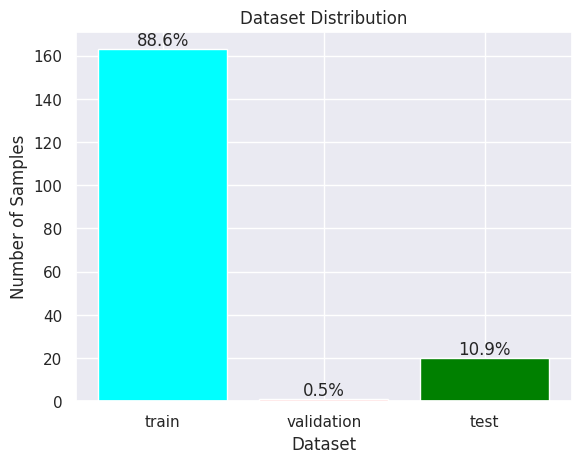

In [ ]:
import matplotlib.pyplot as plt

# Data and labels
data = [len(train_generator), len(validation_generator), len(test_generator)]
labels = ['train', 'validation', 'test']
colors = ['aqua', 'red', 'green']

# Plotting the bar chart
plt.bar(labels, data, color=colors)

# Adding the percentages above the bars
for i, v in enumerate(data):
    plt.text(i, v + max(data)*0.01, f'{(v/sum(data))*100:.1f}%', ha='center')

# Setting the labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Distribution')

# Saving the figure
plt.savefig('dataset_bar.png')

# Displaying the plot
plt.show()


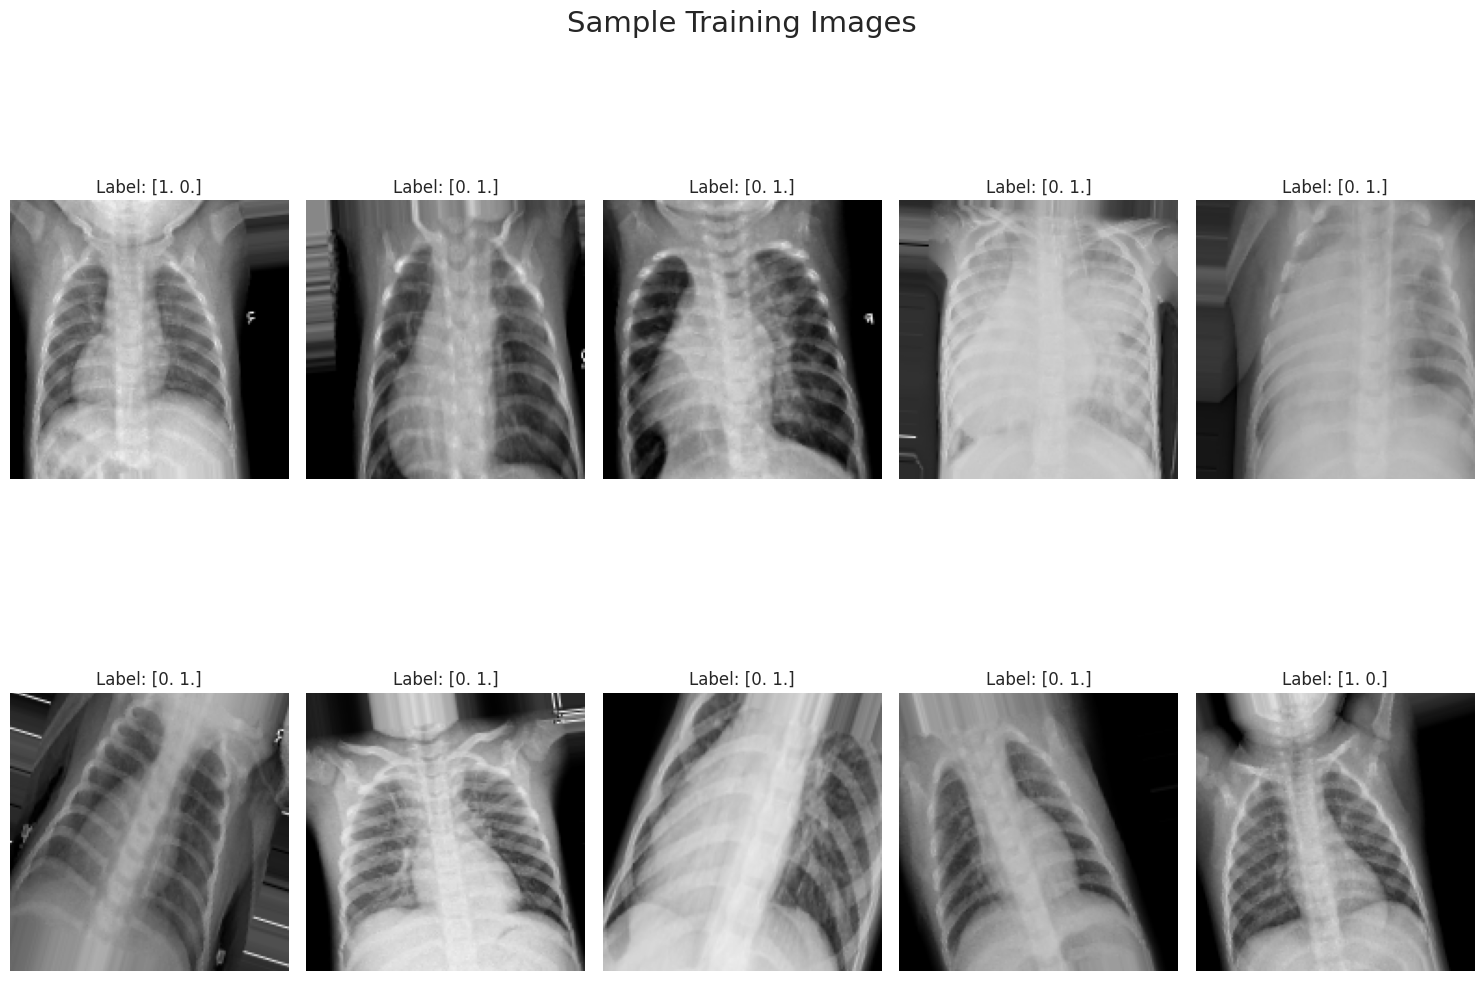

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

train_data, train_labels = train_generator[0]

for i in range(2):
    for j in range(5):
        label = train_labels[idx]
        ax[i, j].set_title(f"Label: {label}")
        ax[i, j].imshow(train_data[idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

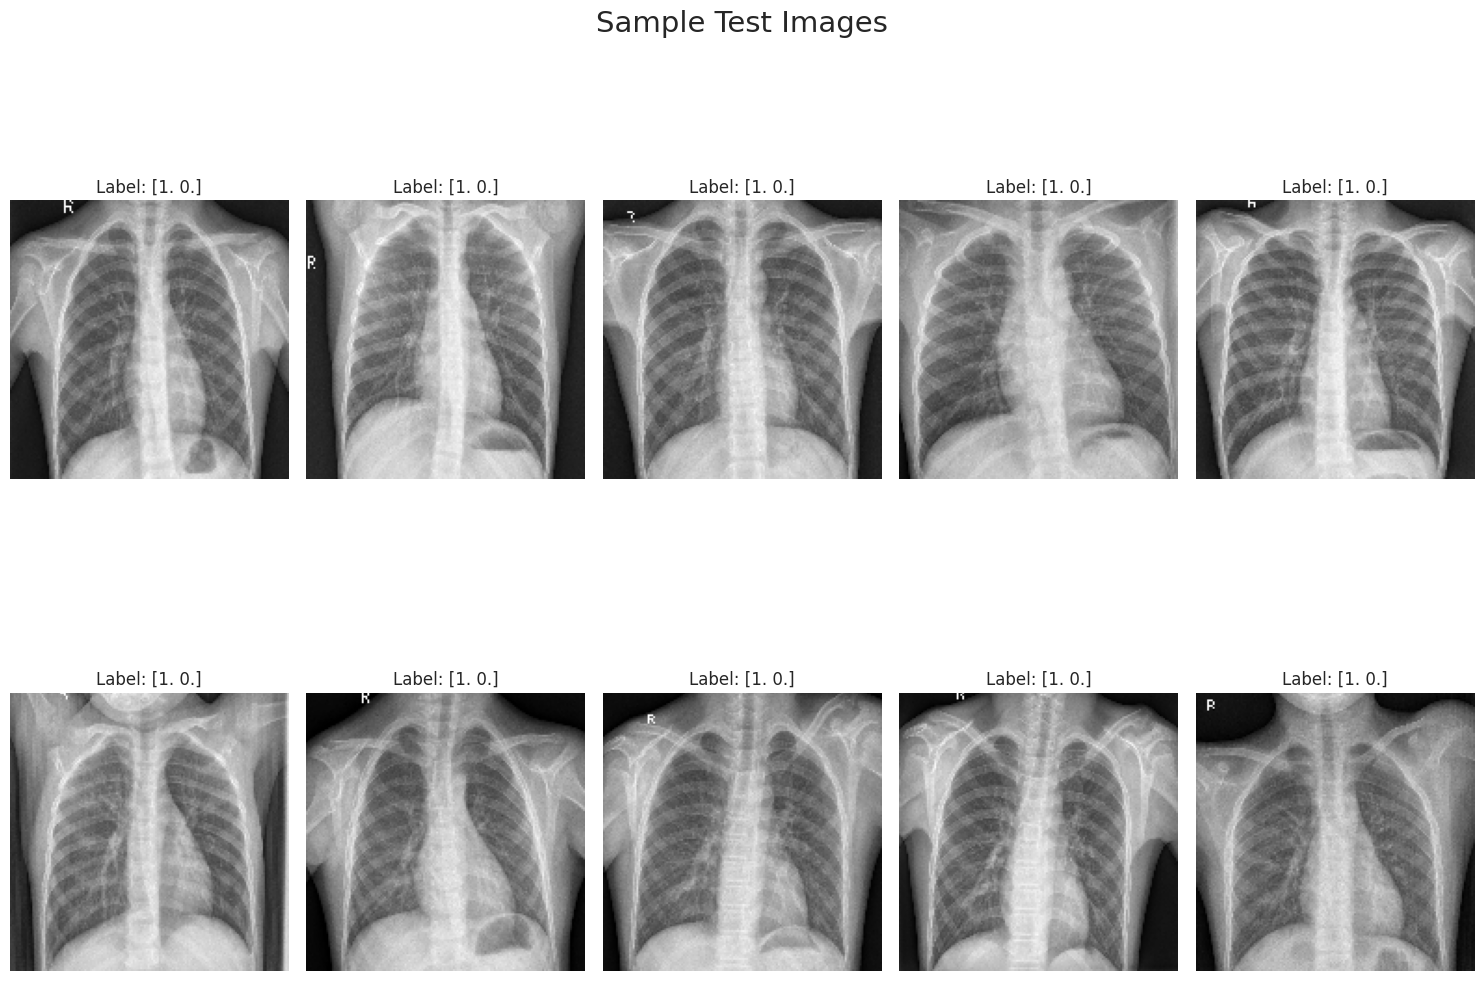

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

train_data, train_labels = test_generator[0]

for i in range(2):
    for j in range(5):
        label = train_labels[idx]
        ax[i, j].set_title(f"Label: {label}")
        ax[i, j].imshow(train_data[idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Test Images", fontsize=21)
plt.show()

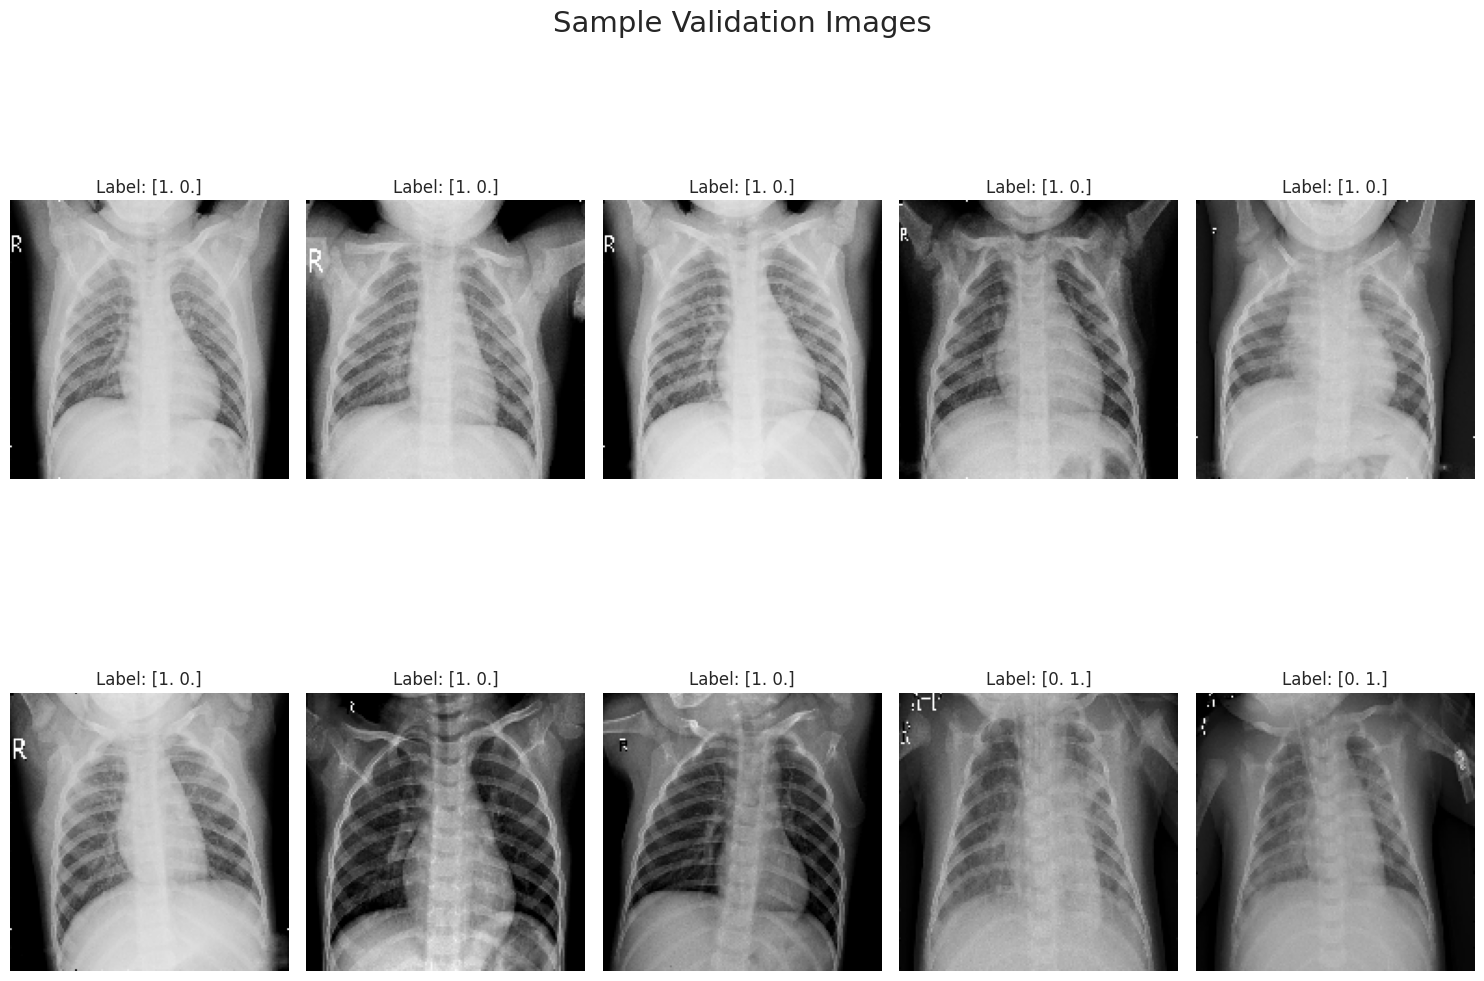

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

train_data, train_labels = validation_generator[0]

for i in range(2):
    for j in range(5):
        label = train_labels[idx]
        ax[i, j].set_title(f"Label: {label}")
        ax[i, j].imshow(train_data[idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Validation Images", fontsize=21)
plt.show()

### Xception Model

In [7]:
from keras import applications
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import layers, models, regularizers


xcep_base = applications.Xception(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
xcep_base.trainable = False

inputs = Input(shape=(150, 150, 3))

x = xcep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation = 'sigmoid')(x)
xcep_model = Model(inputs, outputs)


83683744/83683744 [==============================] - 0s 0us/step


In [8]:
from tensorflow import keras
import matplotlib.pyplot as plt

# Compile the model
xcep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [ ]:


# # Train the model and store the history
# epochs = 10
# history = xcep_model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

# # Extract accuracy and validation accuracy from the history
# acc = history.history['categorical_accuracy']
# val_acc = history.history['val_categorical_accuracy']


Epoch 1/10
163/163 [==============================] - 102s 604ms/step - loss: 0.2751 - categorical_accuracy: 0.8976 - val_loss: 0.3977 - val_categorical_accuracy: 0.8750
Epoch 2/10
163/163 [==============================] - 97s 597ms/step - loss: 0.1647 - categorical_accuracy: 0.9337 - val_loss: 0.3611 - val_categorical_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 98s 599ms/step - loss: 0.1491 - categorical_accuracy: 0.9433 - val_loss: 0.5901 - val_categorical_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 98s 601ms/step - loss: 0.1554 - categorical_accuracy: 0.9406 - val_loss: 0.3502 - val_categorical_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 99s 609ms/step - loss: 0.1500 - categorical_accuracy: 0.9467 - val_loss: 0.4256 - val_categorical_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 99s 606ms/step - loss: 0.1374 - categorical_accuracy: 0.9488 - val_loss: 0.5207 - val_categorical_ac

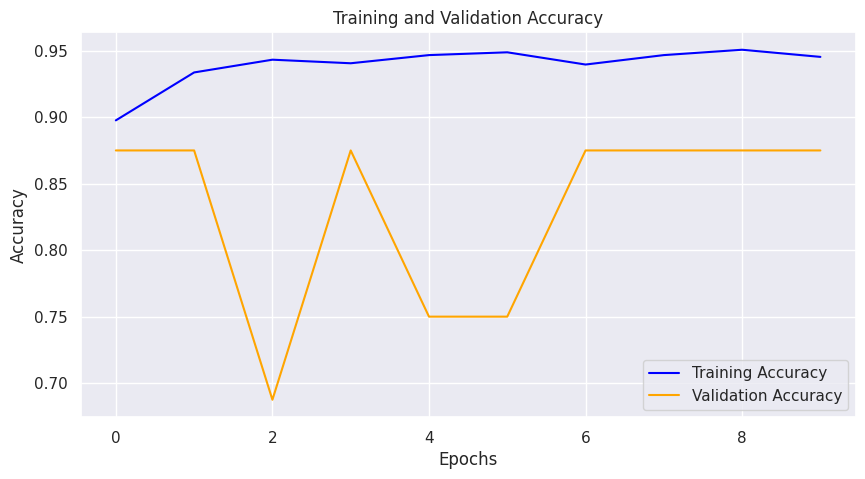

In [ ]:
# # Plot the training and validation accuracy curves
# plt.figure(figsize=(10, 5))
# plt.plot(range(epochs), acc, label='Training Accuracy', color='blue')
# plt.plot(range(epochs), val_acc, label='Validation Accuracy', color='orange')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.grid(True)
# plt.savefig('training_validation_accuracy.png')
# plt.show()


In [ ]:
# # Saving the model weights
# xcep_model.save_weights('xcep_model_weights.h5')


In [9]:
# Load the model weights
xcep_model.load_weights('xcep_model_weights.h5')


In [ ]:
test_loss, test_acc = xcep_model.evaluate(test_generator, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)



accuracy: 0.8846153616905212   loss:  0.30268001556396484


### ResNet 50

In [10]:
from keras.applications import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_base.trainable = False

inputs = Input(shape=(150, 150, 3))

x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='sigmoid')(x)
resnet_model = Model(inputs, outputs)

resnet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/2
163/163 [==============================] - 526s 3s/step - loss: 0.5763 - accuracy: 0.7326 - val_loss: 0.7871 - val_accuracy: 0.5000
Epoch 2/2
163/163 [==============================] - 103s 634ms/step - loss: 0.5076 - accuracy: 0.7504 - val_loss: 0.7948 - val_accuracy: 0.5000


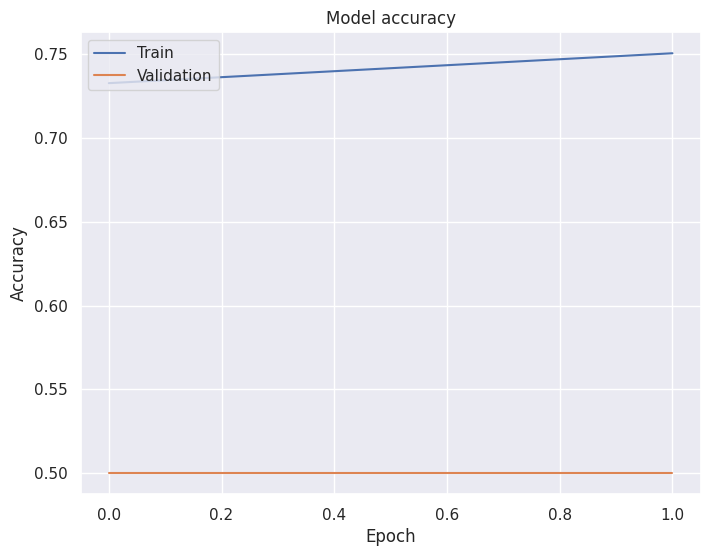

In [ ]:
# history = resnet_model.fit(train_generator, epochs=2, validation_data=validation_generator)

# # Plot training & validation accuracy values
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
# resnet_model.save_weights('resnet_model_weights.h5')

In [ ]:
# test_loss, test_acc = resnet_model.evaluate(test_generator, verbose=0)
# print('\naccuracy:', test_acc, '  loss: ',test_loss)



accuracy: 0.6410256624221802   loss:  0.5688914656639099


In [11]:
# Load the model weights
resnet_model.load_weights('resnet_model_weights.h5')


###MobileNet

In [12]:

from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
mobilenet_base.trainable = False

inputs = Input(shape=(150, 150, 3))

x = mobilenet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='sigmoid')(x)
mobilenet_model = Model(inputs, outputs)

mobilenet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/10
163/163 [==============================] - 168s 682ms/step - loss: 0.2944 - accuracy: 0.8921 - val_loss: 0.5009 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 100s 617ms/step - loss: 0.1733 - accuracy: 0.9319 - val_loss: 0.3293 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 102s 628ms/step - loss: 0.1841 - accuracy: 0.9247 - val_loss: 0.4883 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 103s 632ms/step - loss: 0.1549 - accuracy: 0.9402 - val_loss: 0.3523 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 92s 560ms/step - loss: 0.1442 - accuracy: 0.9436 - val_loss: 0.3850 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 101s 618ms/step - loss: 0.1457 - accuracy: 0.9425 - val_loss: 0.7191 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 102s 627ms/step - loss: 0.1496 - accuracy: 0.9434 - val_loss: 0.2559 - 

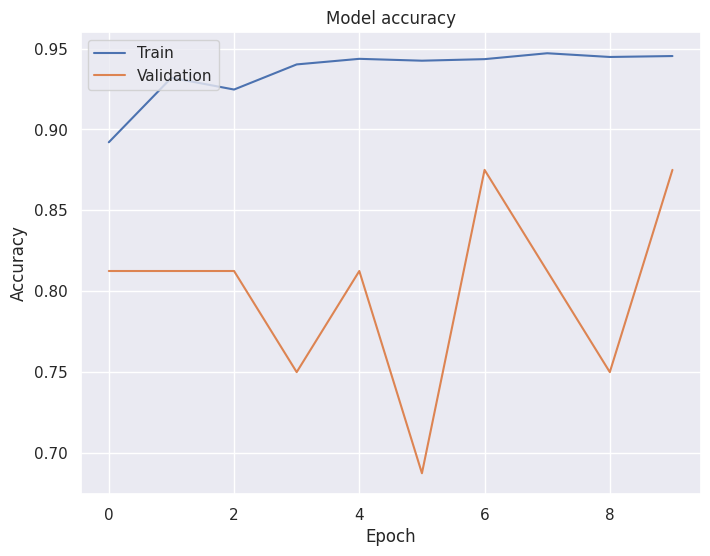

In [ ]:
history = mobilenet_model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
mobilenet_model.save_weights('mobilenet_model_weights.h5')

In [ ]:
test_loss, test_acc = mobilenet_model.evaluate(test_generator, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)



accuracy: 0.879807710647583   loss:  0.2939424514770508


In [13]:
mobilenet_model.load_weights('mobilenet_model_weights.h5')

### Deploying on streamlit

In [17]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [28]:
%%writefile app.py

import tensorflow as tf
import pandas as pd
import numpy as np
import streamlit as st
from PIL import Image
import requests
from io import BytesIO
from tensorflow.keras import layers, Model, Input, applications
from keras.applications import MobileNetV2
from keras.applications import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

st.set_option('deprecation.showfileUploaderEncoding', False)
st.title("Pneumonia Detection Image Classifier")
st.text("Upload a Chest X-ray Image for Pneumonia Detection")


def load_model_xception():
    # Define the model architecture
    xcep_base = applications.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    xcep_base.trainable = False

    inputs = Input(shape=(150, 150, 3))
    x = xcep_base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='sigmoid')(x)
    xcep_model = Model(inputs, outputs)

    # Compile the model with the same configuration
    xcep_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )
    # Load the model weights
    xcep_model.load_weights('xcep_model_weights.h5')
    return xcep_model


def load_model_mobilenet():
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  mobilenet_base.trainable = False

  inputs = Input(shape=(150, 150, 3))

  x = mobilenet_base(inputs, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(2, activation='sigmoid')(x)
  mobilenet_model = Model(inputs, outputs)

  mobilenet_model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  mobilenet_model.load_weights('mobilenet_model_weights.h5')
  return mobilenet_model


def load_model_resnet():
  resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  resnet_base.trainable = False

  inputs = Input(shape=(150, 150, 3))

  x = resnet_base(inputs, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(2, activation='sigmoid')(x)
  resnet_model = Model(inputs, outputs)

  resnet_model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  resnet_model.load_weights('resnet_model_weights.h5')
  return resnet_model


with st.spinner('Loading Models Into Memory....'):
    model_xception = load_model_xception()
    model_mobilenet = load_model_mobilenet()
    model_resnet = load_model_resnet()

st.write("Models Loaded Successfully!")

classes = ['Normal', 'Pneumonia']

def decode_img(image):
    img = tf.image.decode_jpeg(image, channels=3)
    img = tf.image.resize(img, [150, 150])
    img = img / 255.0  # Normalizing the image
    return np.expand_dims(img, axis=0)

uploaded_file = st.file_uploader("Choose a Chest X-ray Image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    try:
        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image', use_column_width=True)

        # Sidebar model selection
        st.sidebar.header('Model Selection')
        model_options = st.sidebar.multiselect(
            'Select the models to use for prediction:',
            ('Xception', 'MobileNetV2', 'ResNet50')
        )

        models = {
            'Xception': model_xception,
            'MobileNetV2': model_mobilenet,
            'ResNet50': model_resnet
        }

        selected_models = [models[model_name] for model_name in model_options]

        if not selected_models:
            st.error("Please select at least one model.")
        else:
            st.write("Predicted Class and Probabilities:")
            with st.spinner('Classifying...'):
                image_array = decode_img(uploaded_file.getvalue())
                all_predictions = [model.predict(image_array) for model in selected_models]

                mean_probabilities = np.mean(all_predictions, axis=0)[0]
                label = np.argmax(mean_probabilities)

            st.write(f"Predicted: {classes[label]}")

            # Aggregate probabilities
            aggregate_data = {
                'Class': classes,
                'Probability': mean_probabilities
            }
            aggregate_df = pd.DataFrame(aggregate_data)
            st.write("Aggregate Probabilities:")
            st.table(aggregate_df)

            # Individual model predictions
            individual_data = {'Class': classes}
            for model_name, prediction in zip(model_options, all_predictions):
                individual_data[model_name] = prediction[0]

            individual_df = pd.DataFrame(individual_data)
            st.write("Individual Model Predictions:")
            st.table(individual_df)

    except Exception as e:
        st.error(f"Error: {e}")

Overwriting app.py


In [29]:
!streamlit run app.py  &  npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.91.172:8501

npx: installed 22 in 2.229s
your url is: https://tough-schools-kick.loca.lt
2024-05-29 11:22:32.371153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 11:22:32.371199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 11:22:32.372496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 11:22:33.691694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [16]:
!wget -q -O - https://loca.lt/mytunnelpassword

35.197.91.172